<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Data Science Tools for Medical Deep Learning
## Modified by Darshan Patel
### Special thanks to <a href="https://www.mayo.edu/research/labs/radiology-informatics/overview">Dr. Bradley J. Erickson M.D., Ph.D.</a>, Department of Radiology, Mayo Clinic, for developing the MedNIST dataset
#### Acknowledgements: Data derived from <a href="http://www.cancerimagingarchive.net/">The Cancer Imaging Archive (TCIA)</a>; <a href ="http://rsnachallenges.cloudapp.net/competitions/4">Radiological Society of North America</a>; <a href= "http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf">National Institute of Health</a>


## Introduction

Advances in deep learning techniques combined with hardware advances such as GPU accelerated computing have led to new applications of artificial intelligence to the healthcare domain, particularly in the fields of radiology and genomics. However, deep learning relies on large, standardized datasets, and the algorithms can perform no better than the data they are provided. This lab will focus on techniques to prepare and augment radiological imaging datasets for use in deep neural networks.

You will be guided through a basic series of exercises to normalize and augment an imaging dataset. While these steps will not apply to every task, this process is similar to what you might use to prepare your data. At the end, you will be able to download the augmented dataset you have created for use in your own deep learning projects.

## Background
Medical imaging presents both a unique opportunity for and a special challenge to deep learning. On the one hand, radiological imaging often involves both volumetric and time series data, providing 4-D datasets for analysis. The images produced tend to be high resolution, and there are often multiple imaging modalities applied to the same patient, providing richer datasets than in many other domains. On the other hand, gathering adequate samples for analysis can be difficult given the constraints of patient privacy and the rarity of some conditions. Also, even in the same imaging modality, devices originating from different manufacturers or different eras can produce subtly different scans that humans adapt to more easily than deep learning algorithms do. Therefore, it is important that we develop techniques to standardize and augment our datasets as necessary.

### Import libraries
The first step in this exercise is to import the code libraries needed. We work with PyTorch, a common framework for deep learning, as it has many built-in functions that allow us to perform complex image manipulations in a single line of code.

Execute code blocks by highlighting them and pressing `Shift+Enter` or the run button above. Also, if you accidentally convert a text cell into its markdown (html-like code) format, `Shift+Enter` will convert it back to the formatted version.

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)


We make use of a modified version of the <a href="https://courses.nvidia.com/courses/course-v1:DLI+L-HX-07+V1/about">MedNIST dataset</a> as our starting point. This dataset was prepared by aggregating images from the sources listed above, standardizing them to the same file format, and resizing them to the same dimensions. PyTorch also has <a href="https://pytorch.org/docs/stable/torchvision/transforms.html">built-in functions</a> that can complete these tasks for us.

Next, we examine the set of images that we have available. The images are sorted into categories, with a separate subdirectory for the files of each. The next codeblock identifies the number and names of image classes, then stores all the image file names and counts the individual members of each class.

In [2]:
dataDir = 'imagedata'             # Location of image data
classNames = os.listdir(dataDir)  # Creates list of class names
numClass = len(classNames)        # Counts number of classses
handClass = classNames.index('Hand')
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEach = [len(imageFiles[i]) for i in range(numClass)]       # Count of each image class
imageWidth, imageHeight = Image.open(imageFiles[0][0]).size  # Image dimensions

for i in range(numClass):
    print("Category",classNames[i],"has",numEach[i],"images")


Category ChestCT has 3912 images
Category CXR has 773 images
Category AbdomenCT has 1960 images
Category Hand has 8437 images
Category HeadCT has 7466 images
Category BreastMRI has 6320 images


As we can see, there are six different categories, but there are different numbers of each. When training a neural network, it is generally advantageous to have balanced numbers of each class; otherwise, the network tends to become biased toward choosing the more numerous category.

We will explore data augmentation techniques to normalize the number of images in each category, but first, we take a look at some of the images available. The code block below can be run multiple times to sample different images.

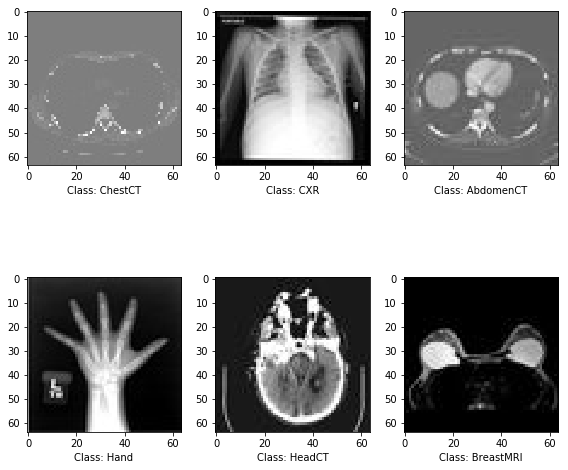

In [3]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass): 
    im = Image.open(imageFiles[i][np.random.randint(numEach[i])])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel('Class: '+classNames[i])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

Note that some of the images are scaled differently than others - that is, they have different maximum and minimum brightness. Before performing the final set of augmentations, we will standardize the brightness of the images.

However, let's explore how some different transformations look without this rescaling procedure. We start with `RandomRotation`, which, as the name suggests, rotates the image by a random number of degrees up to some maximum value in either direction. The unrotated image appears in the upper left corner.

#### Exercise:
Rerun the code block below multiple times, trying different maximum rotation values (change the value of `maxRot`). 

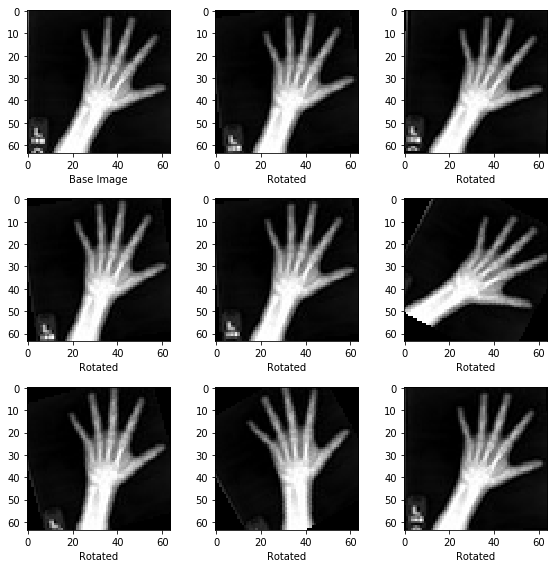

In [4]:
maxRot = 30
randRot = tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[handClass][1])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randRot(baseImage)
    mp.subplot(3,3,i+2)
    mp.xlabel('Rotated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

We can also try random translations. These are performed with the `RandomAffine` transformation function, which includes a more general class of transformations (rotations, translations, shear, rescaling), but with the rest of the options turned off.

The translations are performed as a fraction (0-1) of the entire image size. The x and y translations can be set to different values.

#### Exercise:
Rerun the code block below with several different values of `maxTrX` and/or `maxTrY`

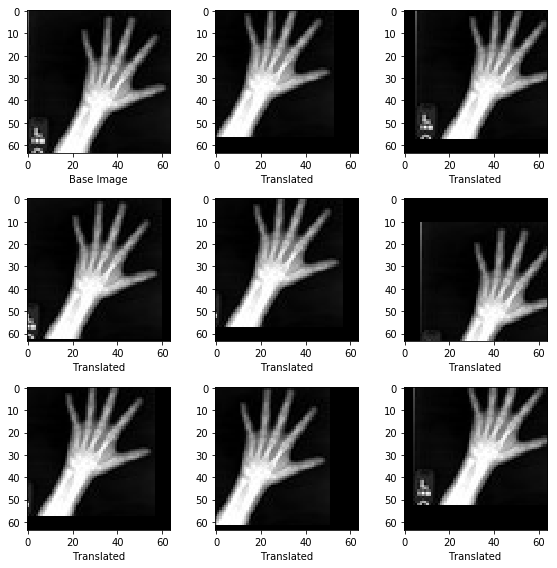

In [5]:
maxTrX = 0.2
maxTrY = 0.2
randTr = tv.transforms.RandomAffine(0,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[handClass][1])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randTr(baseImage)
    arr = np.array(im)
    mp.subplot(3,3,i+2)
    mp.xlabel('Translated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

We next try adding random noise to the images. While the code below produces white noise, in real applications we could produce noise functions that better model specific imaging modalities.

#### Exercise:
Rerun the code block with different values of `noiseStrength`. A value of 0.5 means that the noise will be weighted equally to the image.

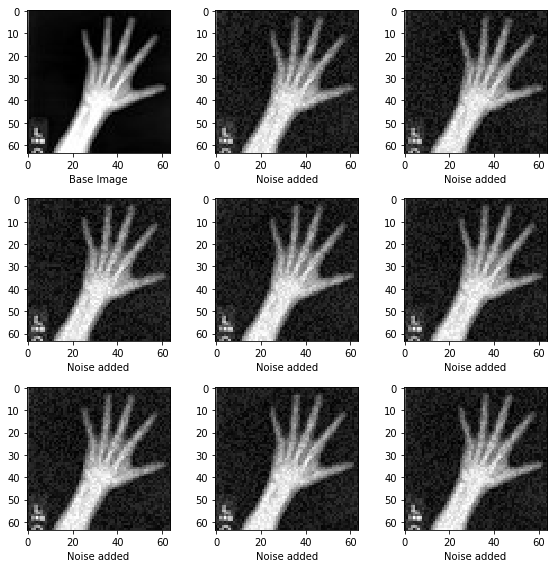

In [6]:
noiseStrength = 0.15
baseImage = Image.open(imageFiles[handClass][1])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    noise = np.random.random((imageWidth,imageHeight))
    arr = np.array(baseImage)*(1-noiseStrength)+255*noiseStrength*noise
    mp.subplot(3,3,i+2)
    mp.xlabel('Noise added')
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

#### Exercise:
Replace `'Hand'` with another image class in the first code block, then rerun the other blocks to see how the transformations look with different source data. 

We define one final scaling function before we combine all these transformations and use them to augment the dataset.

In [7]:
def scaleImage(x):
    y = np.array(x)
    if(np.min(y) < np.max(y)):  # Assuming the image isn't empty, rescale so its values run from 0 to 255
        y = 255.0*(y - 1.0*np.min(y))/(1.0*np.max(y) - np.min(y))
    z = Image.fromarray(np.uint8(y))
    return z


Based on your previous experiments, choose values for the parameters `maxRot`, `maxTrX`, `maxTrY`, and `noiseStrength` that will add some variability to the images without altering them unrecognizably. The code block below will augment each class of image using the combined transformations on randomly chosen source images until the target number of 15000 of each class is reached.

#### NOTE!
This code should only be run once, as it will create image files to augment the dataset. Use the code blocks above to try different parameter values before setting them below and executing the code.

In [8]:
numPerClass = 15000
maxRot = 30
maxTrX = 0.2
maxTrY = 0.2
noiseStrength = 0.15
randAff = tv.transforms.RandomAffine(maxRot,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
for i in range(numClass):
    print('Augmenting class',classNames[i])
    for j in range(numPerClass - numEach[i]):
        if j % 2000 == 0:
            print('Adding image number',j)
        imageID = np.random.randint(numEach[i])
        baseImage = Image.open(imageFiles[i][imageID])
        randImage = randAff(scaleImage(baseImage))
        noise = np.random.random((imageWidth,imageHeight))
        arr = np.array(randImage)*(1-noiseStrength)+255*noiseStrength*noise
        finalImage = Image.fromarray(np.uint8(arr))
        fname = imageFiles[i][imageID][:-5]+str(j)+'a.jpeg'
        finalImage.save(fname)

        


Augmenting class ChestCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Adding image number 8000
Adding image number 10000
Augmenting class CXR
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Adding image number 8000
Adding image number 10000
Adding image number 12000
Adding image number 14000
Augmenting class AbdomenCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Adding image number 8000
Adding image number 10000
Adding image number 12000
Augmenting class Hand
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Augmenting class HeadCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Augmenting class BreastMRI
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Adding image number 8000


Let's double check that the expected files were created by counting the number of images in each class now.

In [9]:
imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEachAug = [len(imageFilesAug[i]) for i in range(numClass)]       # Count of each image class

for i in range(numClass):
    print("Category",classNames[i],"has",numEachAug[i],"images")


Category ChestCT has 15000 images
Category CXR has 15000 images
Category AbdomenCT has 15000 images
Category Hand has 15000 images
Category HeadCT has 15000 images
Category BreastMRI has 15000 images


Run the code block below several times to see examples of both the augmented and original images.

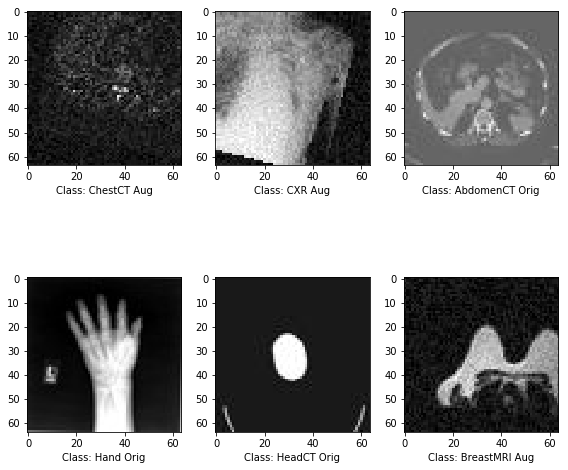

In [10]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass):
    imageID = np.random.randint(numEachAug[i])
    im = Image.open(imageFilesAug[i][imageID])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    if imageFilesAug[i][imageID][-6] == 'a':
        imageType = ' Aug'
    else:
        imageType = ' Orig'
    mp.xlabel('Class: '+classNames[i]+imageType)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

Now you have a balanced and normalized dataset on which to perform your own deep learning experiments. If you'd like to download the dataset onto your laptop, first run the command below to zip the images into an archive (which will take 1 - 2 minutes). Then, click the link below to download the file.

In [ ]:
!tar -czf augmenteddata.tar.gz imagedata

<a href="augmenteddata.tar.gz">Download your dataset!</a>

On the other hand, if you aren't pleased with the results of your augmentation, you can erase them and restore a backup copy by running the code below. <b>Only run the following code block if you want to erase your augmented set!</b> After that, head back up a few cells to the code block where you executed the data augmentation, change the parameters, and give it another try.

In [ ]:
!rm -r imagedata
!cp -r imagebackup imagedata

### When your dataset is ready, <a href="DSMedNIST.ipynb">click here</a> to move on to the second part.